In [139]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('Solarize_Light2')

In [2]:
# load raw data
data = pd.read_stata('data/dataset.dta')
data.vote_trump = data.vote_trump.cat.add_categories(['Unknow']).fillna('Unknow')

In [3]:
# trump voter income levels
data_income = data[['id', 'vote_trump', 'income', 'worry_finances']]

In [4]:
# drop income == 1 rows
data_income = data_income.loc[data_income.income != 0].dropna()

In [15]:
data_income.groupby('vote_trump').mean()

,id,income
vote_trump,,
No,374877.87500,87196.234375
Yes,376291.78125,82576.718750
Unknow,376015.43750,66147.007812


In [6]:
data_income.groupby('worry_finances').mean()

,id,income
worry_finances,,
Not at all worried,363782.31250,104896.773438
A little worried,374507.46875,91736.101562
Moderately worried,379372.56250,72586.882812
Very worried,383095.31250,54695.074219
Extremely worried,380203.31250,55817.843750


In [8]:
data_income.describe()

,id,income
count,3122.000000,3122.000000
mean,375633.437500,80285.820312
std,45847.035156,62601.585938
min,300001.000000,10002.000000
25%,302583.500000,35114.500000
50%,402440.000000,63166.500000
75%,405030.000000,103721.500000
max,407791.000000,299378.000000


# Trump voter with age

In [9]:
data_age = data[['id', 'vote_trump', 'age']].dropna()

In [10]:
# replace 90. Age 90 or older to 90
data_age.age = data_age.age.replace('90. Age 90 or older', 90)

In [32]:
# vote trump distribution
vote_age = data_age.loc[data_age.vote_trump == 'Yes']
vote_age_df = vote_age.groupby('age').count().rename(columns={"vote_trump": "Vote"})

In [49]:
# select not vote trump
not_vote_age = data_age.loc[data_age.vote_trump == 'No']
not_vote_age = not_vote_age.groupby('age').count().rename(columns={"vote_trump": "Not_Vote"})

In [50]:
#select unknow vote
unknown_vote_age = data_age.loc[data_age.vote_trump == 'Unknow'].groupby('age').count().rename(columns={'vote_trump': 'Unknow'})

In [51]:
df_vote = vote_age_df.merge(not_vote_age, left_index=True, right_index=True)
df_vote = df_vote.merge(unknown_vote_age, left_index=True, right_index=True).drop(columns=['id_x', 'id_y', 'id'])

In [59]:
df_vote['Not&Unknow'] = df_vote['Not_Vote'] + df_vote.Unknow
df_vote['num'] = df_vote['Not&Unknow'] + df_vote['Vote']
df_vote['vote%'] = np.round(df_vote['Vote'] / df_vote['num'] * 100, 2)

In [94]:
df_vote = df_vote.reset_index()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


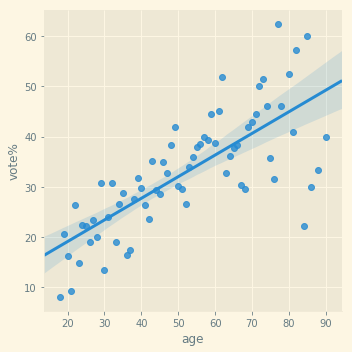

In [144]:
sns.lmplot(x='age', y='vote%', data=df_vote, fit_reg=True)

In [146]:
#df_vote[['age', 'vote%']].plot(kind='scatter', x='age', y='vote%', figsize=(10, 7))

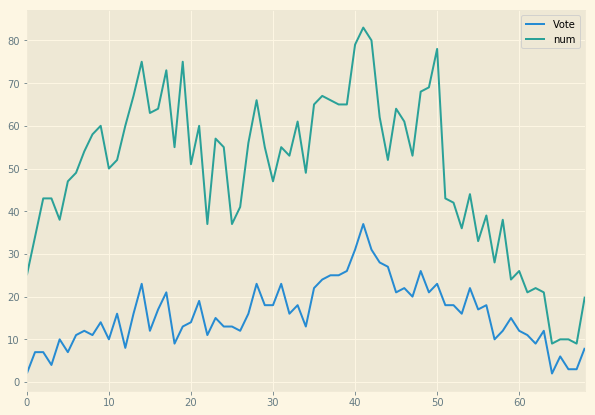

In [145]:
df_vote[['Vote', 'num']].plot(figsize=(10, 7))

# age Vs income

In [77]:
# merge income & age
df_income_age = data_income.merge(data_age, on='id', how='outer').drop(columns=['vote_trump_y']).dropna()

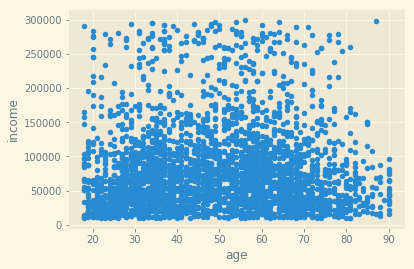

In [150]:
df_income_age.plot(kind='scatter', x='age', y='income')

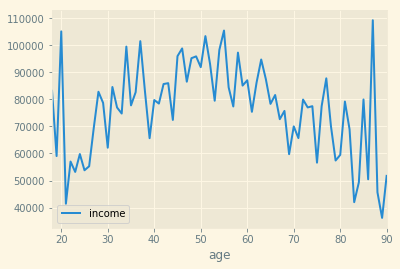

In [149]:
df_income_age.groupby('age').mean().drop(columns=['id']).plot()

In [97]:
df_income_age.groupby('worry_finances').mean()

,id,income,age
worry_finances,,,
Not at all worried,363204.355072,105219.968750,51.085145
A little worried,374443.551043,91420.578125,49.182217
Moderately worried,379274.600646,72556.125000,49.103337
Very worried,383445.065395,54933.105469,46.975477
Extremely worried,380203.298742,55817.843750,47.367925


In [138]:
df_income_age_vote = df_income_age.loc[df_income_age.vote_trump_x == 'Yes'].drop(columns=['id'])

In [135]:
df_income_age_not_vote = df_income_age.loc[df_income_age.vote_trump_x == 'No'].drop(columns=['id'])

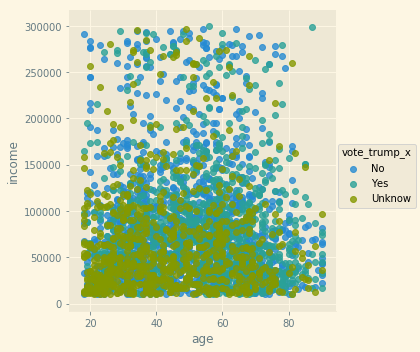

In [148]:
sns.lmplot(x='age', y='income', data=df_income_age, fit_reg=False, hue='vote_trump_x')

# import weight to see if it is relevant with Trump vote

In [104]:
data_weight = data[['id', 'weight', 'vote_trump']].dropna()

In [105]:
data_weight.describe()

,id,weight
count,3538.000000,3538.000000
mean,375419.156250,0.998427
std,45968.320312,0.673717
min,300001.000000,0.089000
25%,302562.500000,0.565000
50%,402446.500000,0.825000
75%,405087.750000,1.245000
max,407799.000000,6.813000


In [111]:
df_weight_age = data_weight.merge(data_age, on='id', how='left').drop(columns=['vote_trump_y']).dropna()